# Predicting Stock Price using Deep Learning

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from indicators import *
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta

## Reading in the Stock Data

In [6]:
#storing the symbols, starting and ending dates for training
ticker = "GOOG"
n_years = 10
end_date =  dt.datetime.today()
start_date = end_date - relativedelta(years=n_years)

In [7]:
#creating a list with the input symbol and "SPY" to pull in all days the stock market was open
symbols = [ticker, "SPY"]

#reading in the stock data (using adjusted stock prices to account for stock splits)
df = yf.download(symbols, start=start_date, end=end_date, auto_adjust=True)

df.head()

[*********************100%***********************]  2 of 2 completed


Close                   High                    Low  \
                  GOOG        SPY        GOOG        SPY        GOOG   
Date                                                                   
2010-03-01  265.350403  91.609451  265.649292  91.699514  262.884644   
2010-03-02  269.519775  91.863258  271.811188  92.305382  266.506073   
2010-03-03  271.641815  91.945145  273.036591  92.493703  268.618164   
2010-03-04  276.259521  92.223518  277.026642  92.354521  272.080170   
2010-03-05  281.051544  93.541718  282.775085  93.615402  278.904602   

                             Open              Volume             
                  SPY        GOOG        SPY     GOOG        SPY  
Date                                                              
2010-03-01  91.019953  263.611908  91.044515  4492500  147709700  
2010-03-02  91.699512  266.740204  92.002450  8746200  160992400  
2010-03-03  91.715891  270.167358  92.100702  6201800  150785000  
2010-03-04  91.724083  272.229614  92.067955  6391300  135770400  
2010-03-05  92.600159  279.626892  92.821223  7853700  176118800

In [8]:
#only keeping Adjusted Closing Stock Price for Google
prices = df['Close'].filter(items=[ticker], axis=1)

#forward and back filling missing prices 
prices.fillna(method='ffill', inplace=True) #forward-filling missing prices
prices.fillna(method='bfill', inplace=True) #back-filling missing prices

prices.head()

,GOOG
Date,
2010-03-01,265.350403
2010-03-02,269.519775
2010-03-03,271.641815
2010-03-04,276.259521
2010-03-05,281.051544


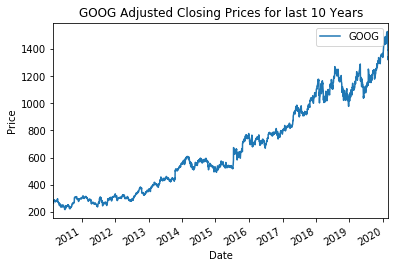

In [9]:
#plotting the adjusted closing prices
prices.plot()
plt.title("{} Adjusted Closing Prices for last {} Years".format(ticker,n_years))
plt.ylabel("Price")
plt.show()

In [10]:
#indicator functions
def generate_indicators(prices, n):
    #generating price Simple Moving Average ratio
    price_sma_df = price_sma_ratio(prices, n)

    #generating the Bollinger Bands indicator
    bb_df = bollinger_bands(prices, n)

    #generating the volatility indicator
    vol_df = volatility(prices, n)
    
    #creating features dataframe for training the regressor
    indicator_names = ["Price/SMA", "Bollinger Bands", "Volatility"]
    indicators_df = price_sma_df.join(bb_df,rsuffix="1") \
                                .join(vol_df,rsuffix="2")
    indicators_df.columns = indicator_names

    #adding column for the closing price one day prior
    indicators_df["Previous Price"] = prices.shift(1).values

    #backfilling indicators
    indicators_df.fillna(method='bfill', inplace=True)
    
    return indicators_df

In [11]:
#splitting the prices into train and test sets
ss = StandardScaler()
cutoff_idx = int(prices.shape[0] * 0.8)
y_train = pd.DataFrame(ss.fit_transform(prices[:cutoff_idx]),index=prices.index[:cutoff_idx], columns=[ticker])
y_test = pd.DataFrame(ss.fit_transform(prices[cutoff_idx:]),index=prices.index[cutoff_idx:], columns=[ticker])

#generating the indicators
n = 10
x_train = generate_indicators(y_train, n)
x_test = generate_indicators(y_test, n)

x_train.head()

,Price/SMA,Bollinger Bands,Volatility,Previous Price
Date,,,,
2010-03-01,0.031737,-0.120261,-0.210546,-1.132074
2010-03-02,0.031737,-0.120261,-0.210546,-1.132074
2010-03-03,0.031737,-0.120261,-0.210546,-1.114456
2010-03-04,0.031737,-0.120261,-0.210546,-1.105489
2010-03-05,0.031737,-0.120261,-0.210546,-1.085977


## Creating the Model

In [12]:
#initializing the model
model = keras.Sequential([
    keras.layers.Dense(128, input_dim=x_train.shape[1], activation='relu'), 
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(1)   
])

In [13]:
#printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [14]:
#compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [15]:
history = model.fit(x_train, y_train, epochs=100)

Train on 2014 samples
Epoch 1/100
2014/2014 [==============================] - 0s 234us/sample - loss: 0.2269 - mean_absolute_error: 0.3263
Epoch 2/100
2014/2014 [==============================] - 0s 39us/sample - loss: 0.0634 - mean_absolute_error: 0.1792
Epoch 3/100
2014/2014 [==============================] - 0s 39us/sample - loss: 0.0670 - mean_absolute_error: 0.1735
Epoch 4/100
2014/2014 [==============================] - 0s 41us/sample - loss: 0.0634 - mean_absolute_error: 0.1593
Epoch 5/100
2014/2014 [==============================] - 0s 39us/sample - loss: 0.0596 - mean_absolute_error: 0.1484
Epoch 6/100
2014/2014 [==============================] - 0s 38us/sample - loss: 0.0451 - mean_absolute_error: 0.1460
Epoch 7/100
2014/2014 [==============================] - ETA: 0s - loss: 0.0454 - mean_absolute_error: 0.141 - 0s 40us/sample - loss: 0.0432 - mean_absolute_error: 0.1384
Epoch 8/100
2014/2014 [==============================] - 0s 41us/sample - loss: 0.0401 - mean_absolute_e

2014/2014 [==============================] - 0s 37us/sample - loss: 0.0177 - mean_absolute_error: 0.0961
Epoch 69/100
2014/2014 [==============================] - 0s 39us/sample - loss: 0.0170 - mean_absolute_error: 0.0938
Epoch 70/100
2014/2014 [==============================] - 0s 37us/sample - loss: 0.0182 - mean_absolute_error: 0.0960
Epoch 71/100
2014/2014 [==============================] - 0s 37us/sample - loss: 0.0179 - mean_absolute_error: 0.0956
Epoch 72/100
2014/2014 [==============================] - 0s 35us/sample - loss: 0.0175 - mean_absolute_error: 0.0937
Epoch 73/100
2014/2014 [==============================] - 0s 36us/sample - loss: 0.0190 - mean_absolute_error: 0.0974
Epoch 74/100
2014/2014 [==============================] - 0s 31us/sample - loss: 0.0176 - mean_absolute_error: 0.0947
Epoch 75/100
2014/2014 [==============================] - 0s 44us/sample - loss: 0.0171 - mean_absolute_error: 0.0936
Epoch 76/100
2014/2014 [==============================] - 0s 39us/sam

In [16]:
model.evaluate(x_test, y_test)

504/504 [==============================] - 0s 134us/sample - loss: 0.0238 - mean_absolute_error: 0.1093


[0.02380956928171809, 0.10934366]

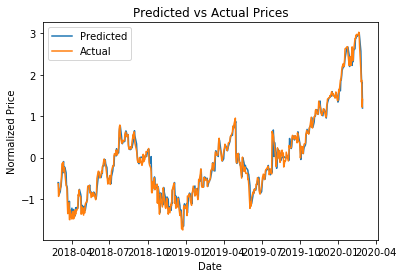

In [17]:
#plotting the predicted and actual normalized test prices
y_pred = model.predict(x_test)
plt.plot(y_test.index, y_pred,  label="Predicted")
plt.plot(y_test.index, y_test, label="Actual")
plt.title("Predicted vs Actual Prices")
plt.ylabel("Normalized Price")
plt.xlabel("Date")
plt.legend()
plt.show()

In [18]:
#calculating the Mean Absolute Error of the non-normalized prices
pred_prices = ss.inverse_transform(y_pred)
act_prices = prices[cutoff_idx:]
abs_diff = np.abs(pred_prices.flatten() - act_prices.values)
mae = np.mean(abs_diff)

print("Mean Absolute Error of Stock Prices: ${:,.2f}".format(mae))

Mean Absolute Error of Stock Prices: $124.74


## Closing Remarks
Even though the plot and Mean Absolute Error look great, I would still hesitate to use this model for making stock trading decisions. The main reason the predicted price closely follows the actual price is because the previous day's stock price is included as an input in the model. I decided to include this because, if I were to actually use this model to make decisions, I would use the model along with my MLTrader in my Stock Price Prediction App to make **daily** buy/sell decisions automatically each morning, so I would already know the closing price from the previous day.     
  
My plan in the future is to backtest the model with that objective in mind to see if I could fully automate my stock trading decisions.